In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [15]:
class LinearSVM:
    def __init__(self, C):
        self.C = C
    
    def loss(self, y, y_cap):
        hinge_loss_params = 1-y*y_cap
        hinge_loss = np.sum(np.where(hinge_loss_params<0, 0, hinge_loss_params)) / len(y)
        regularization_loss = sum(self.W**2)/2
        return self.C * hinge_loss + regularization_loss
    
    def compute_gradients(self, X, Y, Y_cap, n):
        # differentiation of [1/2 * W**2 + C * (1-y*(W*X+b))]
        
        dW = (-self.C * np.multiply(Y, X.T).T + self.W).T
        for i in range(self.W.shape[0]):
            dW[i] = np.where(1-Y_cap <= 0, self.W[i], dW[i])
        dW = np.sum(dW, axis=1)
        dW = dW/n
        
        db = -Y * self.b
        db = np.where(1-Y_cap <= 0, 0, db)
        db = sum(db)
        db = db / n
        
        return dW, db
    
    def train(self, X, Y, epochs, lr):
        n_instances = X.shape[0]
        n_features = X.shape[1]
        
        # TODO: Should maybe try random initialization and check performance...
        self.W = np.zeros(n_features)
        # TODO: Initializing this to random doesnt generate decision boundary for circles... Why?
        self.b = 0.0
        
        for epoch in range(epochs):
            y_cap = np.dot(X,self.W) + self.b
            loss = self.loss(Y, y_cap)
            print("Epoch No: " + str(epoch) + ", Loss: " + str(loss))
            dW, db = self.compute_gradients(X, Y, y_cap, n_instances)
            self.W -= lr * dW
            self.b -= lr * db
    
    def predict(self, X):
        return np.where(np.dot(X, self.W) + self.b > 0, 1, -1)
    
    def evaluate(self, X, Y):
        y_cap = self.predict(X)
        acc = len(np.where(y_cap == Y)[0]) / len(Y)
        return acc

In [16]:
def decision_boundary(model, X, Y):
    X1_min, X1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    X2_min, X2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    XX, YY = np.meshgrid(np.arange(X1_min, X1_max, 0.02), np.arange(X2_min, X2_max, 0.02))

    Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    
    plt.scatter(X[np.where(Y==-1)[0], 0], X[np.where(Y==-1)[0], 1], label='-1')
    plt.scatter(X[np.where(Y==1)[0], 0], X[np.where(Y==1)[0], 1], label='1')
    plt.contour(XX, YY, Z, cmap=plt.cm.Paired)
    plt.legend()
    plt.show()

In [17]:
class LogisticRegression:

    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

    def compute_gradients(self, X_train, Y_train, Y_cap):
        dw = np.dot(X_train.T, (Y_cap - Y_train)) / Y_train.shape[0]
        db = np.sum((Y_cap - Y_train)) / Y_train.shape[0]
        return  dw, db

    def train(self, X, Y, n_iter, alpha):
        W = np.zeros(X.shape[1])
        b = 0
        for i in range(n_iter):
            y_cap = self.sigmoid(np.dot(X, W) + b)
            dw, db = self.compute_gradients(X, Y, y_cap)
            W = W - alpha * dw
            b = b - alpha * db
        self.W = W
        self.b = b
        return

    def predict(self, X):
        y_cap = self.sigmoid(np.dot(X, self.W) + self.b)
        y_pred = [1 if i > 0.5 else 0 for i in y_cap]
        return np.array(y_pred)
    
    def evaluate(self, X, Y):
        y_pred = self.predict(X)
        acc = len(np.where(y_pred == Y)[0]) / len(Y)
        return acc

In [53]:
means = np.arange(1, 2.5, 0.2)

In [54]:
svm_accuracies = []
lr_accuracies = []
gnb_accuracies = []
knn_accuracies = []

In [55]:
for mean in means:
    X = np.vstack((np.random.multivariate_normal([mean, 0.0], np.identity(2), 750), np.random.multivariate_normal([-mean, 0.0], np.identity(2), 750)))
    Y = np.concatenate((np.zeros(750), np.ones(750)))
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=250, random_state=1)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=250, random_state=1)
    
    Y_train_neg, Y_test_neg = Y_train.copy(), Y_test.copy()
    Y_train_neg[np.where(Y_train_neg==0)] = -1
    Y_test_neg[np.where(Y_test_neg==0)] = -1
    
    svm = LinearSVM(C=1)
    svm.train(X_train, Y_train_neg, 1000, 0.001)
    svm_accuracies.append(svm.evaluate(X_test, Y_test_neg))
    
    lr = LogisticRegression()
    lr.train(X_train, Y_train, n_iter=1000, alpha=0.1)
    lr_accuracies.append(lr.evaluate(X_test, Y_test))
    
    GNB = GaussianNB()
    GNB.fit(X_train, Y_train)
    gnb_accuracies.append(GNB.score(X_test, Y_test))
    
    KNN = KNeighborsClassifier()
    KNN.fit(X_train, Y_train)
    knn_accuracies.append(KNN.score(X_test, Y_test))


Epoch No: 0, Loss: 1.0
Epoch No: 1, Loss: 0.9989789125745441
Epoch No: 2, Loss: 0.9979598663028516
Epoch No: 3, Loss: 0.9969428571046562
Epoch No: 4, Loss: 0.9959278809078481
Epoch No: 5, Loss: 0.9949149336484574
Epoch No: 6, Loss: 0.9939040112706381
Epoch No: 7, Loss: 0.9928951097266523
Epoch No: 8, Loss: 0.9918882249768527
Epoch No: 9, Loss: 0.9908833529896681
Epoch No: 10, Loss: 0.9898804897415858
Epoch No: 11, Loss: 0.9888796312171363
Epoch No: 12, Loss: 0.9878807734088775
Epoch No: 13, Loss: 0.9868839123173772
Epoch No: 14, Loss: 0.9858890439511988
Epoch No: 15, Loss: 0.9848961643268844
Epoch No: 16, Loss: 0.9839052694689391
Epoch No: 17, Loss: 0.9829163554098147
Epoch No: 18, Loss: 0.9819294181898944
Epoch No: 19, Loss: 0.980944453857477
Epoch No: 20, Loss: 0.9799614584687599
Epoch No: 21, Loss: 0.9789804280878248
Epoch No: 22, Loss: 0.9780013587866214
Epoch No: 23, Loss: 0.9770242466449511
Epoch No: 24, Loss: 0.9760490877504518
Epoch No: 25, Loss: 0.9750758781985828
Epoch No: 26

Epoch No: 750, Loss: 0.6608628817769973
Epoch No: 751, Loss: 0.6608278536622786
Epoch No: 752, Loss: 0.6607929664924908
Epoch No: 753, Loss: 0.6607587420638802
Epoch No: 754, Loss: 0.6607247898027171
Epoch No: 755, Loss: 0.6606911198162351
Epoch No: 756, Loss: 0.660658267972258
Epoch No: 757, Loss: 0.66062623136988
Epoch No: 758, Loss: 0.6605943301615086
Epoch No: 759, Loss: 0.6605625640051384
Epoch No: 760, Loss: 0.6605309325595193
Epoch No: 761, Loss: 0.6604994354841541
Epoch No: 762, Loss: 0.6604680724392976
Epoch No: 763, Loss: 0.6604368430859552
Epoch No: 764, Loss: 0.6604057470858804
Epoch No: 765, Loss: 0.6603749076304261
Epoch No: 766, Loss: 0.6603449095043414
Epoch No: 767, Loss: 0.6603150416198651
Epoch No: 768, Loss: 0.6602856080886355
Epoch No: 769, Loss: 0.6602566295813127
Epoch No: 770, Loss: 0.6602277796960203
Epoch No: 771, Loss: 0.6601990581049488
Epoch No: 772, Loss: 0.6601704644810146
Epoch No: 773, Loss: 0.6601419984978587
Epoch No: 774, Loss: 0.6601136598298455
Epo

Epoch No: 171, Loss: 0.7799786703824626
Epoch No: 172, Loss: 0.778900676906667
Epoch No: 173, Loss: 0.7778248383398296
Epoch No: 174, Loss: 0.7767511503742871
Epoch No: 175, Loss: 0.7756796087109877
Epoch No: 176, Loss: 0.7746102090594736
Epoch No: 177, Loss: 0.7735429471378625
Epoch No: 178, Loss: 0.7724778186728329
Epoch No: 179, Loss: 0.7714148193996049
Epoch No: 180, Loss: 0.770353945061924
Epoch No: 181, Loss: 0.769295191412044
Epoch No: 182, Loss: 0.7682385542107103
Epoch No: 183, Loss: 0.7671840292271421
Epoch No: 184, Loss: 0.766131612239016
Epoch No: 185, Loss: 0.765081299032449
Epoch No: 186, Loss: 0.7640330854019822
Epoch No: 187, Loss: 0.7629869671505626
Epoch No: 188, Loss: 0.7619429400895276
Epoch No: 189, Loss: 0.7609010000385875
Epoch No: 190, Loss: 0.7598611428258093
Epoch No: 191, Loss: 0.7588233642875994
Epoch No: 192, Loss: 0.7577876602686875
Epoch No: 193, Loss: 0.7567540266221092
Epoch No: 194, Loss: 0.7557224592091906
Epoch No: 195, Loss: 0.7546929538995304
Epoch

Epoch No: 833, Loss: 0.5753726877457754
Epoch No: 834, Loss: 0.5754108999301903
Epoch No: 835, Loss: 0.5754494458125106
Epoch No: 836, Loss: 0.5754883540851462
Epoch No: 837, Loss: 0.5755272894312923
Epoch No: 838, Loss: 0.5755662516919776
Epoch No: 839, Loss: 0.5756052407086539
Epoch No: 840, Loss: 0.5756442563231943
Epoch No: 841, Loss: 0.5756832983778928
Epoch No: 842, Loss: 0.5757223667154631
Epoch No: 843, Loss: 0.5757614611790378
Epoch No: 844, Loss: 0.5758013024229693
Epoch No: 845, Loss: 0.5758413167880763
Epoch No: 846, Loss: 0.5758813559458893
Epoch No: 847, Loss: 0.5759214197420665
Epoch No: 848, Loss: 0.575961508022679
Epoch No: 849, Loss: 0.5760017924492205
Epoch No: 850, Loss: 0.5760420788142327
Epoch No: 851, Loss: 0.576082506776828
Epoch No: 852, Loss: 0.5761229566690059
Epoch No: 853, Loss: 0.576163428344184
Epoch No: 854, Loss: 0.5762039216561758
Epoch No: 855, Loss: 0.5762444364591897
Epoch No: 856, Loss: 0.5762849726078279
Epoch No: 857, Loss: 0.5763255299570857
Epo

Epoch No: 351, Loss: 0.5447263774706526
Epoch No: 352, Loss: 0.5442551372195034
Epoch No: 353, Loss: 0.5437915182330633
Epoch No: 354, Loss: 0.5433318749543748
Epoch No: 355, Loss: 0.5428735531921158
Epoch No: 356, Loss: 0.5424194422824931
Epoch No: 357, Loss: 0.5419734874154403
Epoch No: 358, Loss: 0.5415335671786143
Epoch No: 359, Loss: 0.5410970924247541
Epoch No: 360, Loss: 0.5406651726134217
Epoch No: 361, Loss: 0.5402379606705573
Epoch No: 362, Loss: 0.5398123005249905
Epoch No: 363, Loss: 0.5393879240014331
Epoch No: 364, Loss: 0.5389670362088848
Epoch No: 365, Loss: 0.5385508716632332
Epoch No: 366, Loss: 0.5381374659291491
Epoch No: 367, Loss: 0.5377258953613768
Epoch No: 368, Loss: 0.5373192140023169
Epoch No: 369, Loss: 0.5369185845671841
Epoch No: 370, Loss: 0.536520148714066
Epoch No: 371, Loss: 0.5361243639386852
Epoch No: 372, Loss: 0.5357357277069198
Epoch No: 373, Loss: 0.5353546235863207
Epoch No: 374, Loss: 0.5349762756886571
Epoch No: 375, Loss: 0.5346034260255873
E

Epoch No: 0, Loss: 1.0
Epoch No: 1, Loss: 0.9975761241366322
Epoch No: 2, Loss: 0.9951570936011152
Epoch No: 3, Loss: 0.9927428987076388
Epoch No: 4, Loss: 0.9903335297897542
Epoch No: 5, Loss: 0.9879289772003366
Epoch No: 6, Loss: 0.9855292313115455
Epoch No: 7, Loss: 0.9831342825147857
Epoch No: 8, Loss: 0.9807441212206708
Epoch No: 9, Loss: 0.9783587378589828
Epoch No: 10, Loss: 0.9759781228786348
Epoch No: 11, Loss: 0.9736022667476326
Epoch No: 12, Loss: 0.9712311599530362
Epoch No: 13, Loss: 0.9688647930009222
Epoch No: 14, Loss: 0.9665031564163455
Epoch No: 15, Loss: 0.9641462407433015
Epoch No: 16, Loss: 0.9617940365446876
Epoch No: 17, Loss: 0.959446534402267
Epoch No: 18, Loss: 0.9571037249166291
Epoch No: 19, Loss: 0.9547655987071529
Epoch No: 20, Loss: 0.9524321464119694
Epoch No: 21, Loss: 0.9501033586879238
Epoch No: 22, Loss: 0.947779226210539
Epoch No: 23, Loss: 0.9454597396739762
Epoch No: 24, Loss: 0.9431448897910001
Epoch No: 25, Loss: 0.9408346672929401
Epoch No: 26,

Epoch No: 615, Loss: 0.45028630300645045
Epoch No: 616, Loss: 0.4503306299578619
Epoch No: 617, Loss: 0.45037576746346364
Epoch No: 618, Loss: 0.4504210392584883
Epoch No: 619, Loss: 0.4504664448499722
Epoch No: 620, Loss: 0.4505119837461614
Epoch No: 621, Loss: 0.4505576554565094
Epoch No: 622, Loss: 0.45060359376308
Epoch No: 623, Loss: 0.45065025989841767
Epoch No: 624, Loss: 0.45069705665322823
Epoch No: 625, Loss: 0.4507440695317858
Epoch No: 626, Loss: 0.45079164809633576
Epoch No: 627, Loss: 0.4508393538803834
Epoch No: 628, Loss: 0.45088718640728753
Epoch No: 629, Loss: 0.4509358312074667
Epoch No: 630, Loss: 0.4509849389067518
Epoch No: 631, Loss: 0.4510343762903837
Epoch No: 632, Loss: 0.45108393586276363
Epoch No: 633, Loss: 0.4511336171586225
Epoch No: 634, Loss: 0.45118341971384174
Epoch No: 635, Loss: 0.4512333430654517
Epoch No: 636, Loss: 0.4512847261411214
Epoch No: 637, Loss: 0.4513358519042456
Epoch No: 638, Loss: 0.4513876887692726
Epoch No: 639, Loss: 0.45143998110

Epoch No: 183, Loss: 0.5030242699088059
Epoch No: 184, Loss: 0.5012688842670433
Epoch No: 185, Loss: 0.499536041377729
Epoch No: 186, Loss: 0.49780739616472486
Epoch No: 187, Loss: 0.49609270726751076
Epoch No: 188, Loss: 0.49438902337476054
Epoch No: 189, Loss: 0.4927084922979844
Epoch No: 190, Loss: 0.49106139116061986
Epoch No: 191, Loss: 0.4894243200146955
Epoch No: 192, Loss: 0.4878053251184933
Epoch No: 193, Loss: 0.48620445785733696
Epoch No: 194, Loss: 0.4846241513875069
Epoch No: 195, Loss: 0.4830567512059094
Epoch No: 196, Loss: 0.4815143249210857
Epoch No: 197, Loss: 0.47999352576132287
Epoch No: 198, Loss: 0.47848091547699784
Epoch No: 199, Loss: 0.4769894330334898
Epoch No: 200, Loss: 0.4755164753246607
Epoch No: 201, Loss: 0.47405503709945707
Epoch No: 202, Loss: 0.47260357226176397
Epoch No: 203, Loss: 0.4711715391079161
Epoch No: 204, Loss: 0.4697742986075596
Epoch No: 205, Loss: 0.4683901058340097
Epoch No: 206, Loss: 0.46702454786294434
Epoch No: 207, Loss: 0.46566699

Epoch No: 841, Loss: 0.41753709337463674
Epoch No: 842, Loss: 0.41767247673714214
Epoch No: 843, Loss: 0.4178078153404544
Epoch No: 844, Loss: 0.4179431090481751
Epoch No: 845, Loss: 0.4180783577244041
Epoch No: 846, Loss: 0.4182137171691138
Epoch No: 847, Loss: 0.4183486272236666
Epoch No: 848, Loss: 0.4184834912676798
Epoch No: 849, Loss: 0.41861830916945364
Epoch No: 850, Loss: 0.4187530807977756
Epoch No: 851, Loss: 0.4188878060219188
Epoch No: 852, Loss: 0.4190225175000856
Epoch No: 853, Loss: 0.4191575717274364
Epoch No: 854, Loss: 0.4192925787391285
Epoch No: 855, Loss: 0.4194275384067881
Epoch No: 856, Loss: 0.41956245060252106
Epoch No: 857, Loss: 0.4196973151989112
Epoch No: 858, Loss: 0.41983244127442415
Epoch No: 859, Loss: 0.4199670064175732
Epoch No: 860, Loss: 0.4201015229478898
Epoch No: 861, Loss: 0.4202359907421681
Epoch No: 862, Loss: 0.4203704096776689
Epoch No: 863, Loss: 0.42050477963211885
Epoch No: 864, Loss: 0.42063910048370823
Epoch No: 865, Loss: 0.4207733721

Epoch No: 191, Loss: 0.40014224968889833
Epoch No: 192, Loss: 0.39866247608045663
Epoch No: 193, Loss: 0.3971980432559066
Epoch No: 194, Loss: 0.3957518360759822
Epoch No: 195, Loss: 0.3943149305998709
Epoch No: 196, Loss: 0.39290447157186437
Epoch No: 197, Loss: 0.39152968398568055
Epoch No: 198, Loss: 0.39017513229102674
Epoch No: 199, Loss: 0.3888433089906109
Epoch No: 200, Loss: 0.38753070769006837
Epoch No: 201, Loss: 0.38622936340494934
Epoch No: 202, Loss: 0.38495122004012994
Epoch No: 203, Loss: 0.38368439227127554
Epoch No: 204, Loss: 0.38242927137436794
Epoch No: 205, Loss: 0.38119725775405466
Epoch No: 206, Loss: 0.37998365284800245
Epoch No: 207, Loss: 0.37877971113634307
Epoch No: 208, Loss: 0.3775960903069188
Epoch No: 209, Loss: 0.3764273667097928
Epoch No: 210, Loss: 0.3752634010800827
Epoch No: 211, Loss: 0.37411370363948415
Epoch No: 212, Loss: 0.37298903569566316
Epoch No: 213, Loss: 0.3718871819206347
Epoch No: 214, Loss: 0.3708008509788886
Epoch No: 215, Loss: 0.36

Epoch No: 859, Loss: 0.37932332831388604
Epoch No: 860, Loss: 0.3794914793331704
Epoch No: 861, Loss: 0.3796588849744125
Epoch No: 862, Loss: 0.37982621841597247
Epoch No: 863, Loss: 0.3799934795397334
Epoch No: 864, Loss: 0.38016067122956926
Epoch No: 865, Loss: 0.38032820106972
Epoch No: 866, Loss: 0.3804956578270025
Epoch No: 867, Loss: 0.3806630413857002
Epoch No: 868, Loss: 0.3808303516305895
Epoch No: 869, Loss: 0.38099758844693876
Epoch No: 870, Loss: 0.3811647517205071
Epoch No: 871, Loss: 0.3813318807197052
Epoch No: 872, Loss: 0.38149930073808663
Epoch No: 873, Loss: 0.38166682349512676
Epoch No: 874, Loss: 0.3818345067380501
Epoch No: 875, Loss: 0.3820021150590305
Epoch No: 876, Loss: 0.38216964834756006
Epoch No: 877, Loss: 0.3823371064936122
Epoch No: 878, Loss: 0.38250448938764015
Epoch No: 879, Loss: 0.38267179692057574
Epoch No: 880, Loss: 0.3828393420697004
Epoch No: 881, Loss: 0.38300690396069287
Epoch No: 882, Loss: 0.3831743897608438
Epoch No: 883, Loss: 0.383341799

Epoch No: 359, Loss: 0.26362240335025056
Epoch No: 360, Loss: 0.26372254343617385
Epoch No: 361, Loss: 0.26382347144142393
Epoch No: 362, Loss: 0.26392641675014406
Epoch No: 363, Loss: 0.26403194253371115
Epoch No: 364, Loss: 0.2641393899250892
Epoch No: 365, Loss: 0.2642485345889247
Epoch No: 366, Loss: 0.2643606900942953
Epoch No: 367, Loss: 0.26447389729505466
Epoch No: 368, Loss: 0.26458760008541693
Epoch No: 369, Loss: 0.2647030437604491
Epoch No: 370, Loss: 0.2648217192240512
Epoch No: 371, Loss: 0.2649408783628494
Epoch No: 372, Loss: 0.2650605194890696
Epoch No: 373, Loss: 0.2651806409190324
Epoch No: 374, Loss: 0.2653012409731442
Epoch No: 375, Loss: 0.2654223179758885
Epoch No: 376, Loss: 0.2655444469869137
Epoch No: 377, Loss: 0.265667594301319
Epoch No: 378, Loss: 0.26579228935201227
Epoch No: 379, Loss: 0.2659174469123835
Epoch No: 380, Loss: 0.2660442475381276
Epoch No: 381, Loss: 0.26617170261905543
Epoch No: 382, Loss: 0.2663022084310244
Epoch No: 383, Loss: 0.266435432

Epoch No: 0, Loss: 1.0
Epoch No: 1, Loss: 0.9941295556656765
Epoch No: 2, Loss: 0.9882708463495772
Epoch No: 3, Loss: 0.9824238485934008
Epoch No: 4, Loss: 0.9765885389857392
Epoch No: 5, Loss: 0.970764894161983
Epoch No: 6, Loss: 0.9649528908042297
Epoch No: 7, Loss: 0.9591525056411885
Epoch No: 8, Loss: 0.9533637154480882
Epoch No: 9, Loss: 0.9475864970465838
Epoch No: 10, Loss: 0.9418208273046642
Epoch No: 11, Loss: 0.9360666831365587
Epoch No: 12, Loss: 0.9303240415026451
Epoch No: 13, Loss: 0.9245928794093577
Epoch No: 14, Loss: 0.9188731739090951
Epoch No: 15, Loss: 0.9131649021001271
Epoch No: 16, Loss: 0.9074680411265055
Epoch No: 17, Loss: 0.90178256817797
Epoch No: 18, Loss: 0.8961084604898587
Epoch No: 19, Loss: 0.8904456953430159
Epoch No: 20, Loss: 0.8847942500637017
Epoch No: 21, Loss: 0.8791541020235007
Epoch No: 22, Loss: 0.8735252286392322
Epoch No: 23, Loss: 0.8679076073728588
Epoch No: 24, Loss: 0.862301215731397
Epoch No: 25, Loss: 0.8567060312668263
Epoch No: 26, L

Epoch No: 567, Loss: 0.29600142011394887
Epoch No: 568, Loss: 0.2963028074653004
Epoch No: 569, Loss: 0.29660435436699806
Epoch No: 570, Loss: 0.29690609277356866
Epoch No: 571, Loss: 0.29720880414880946
Epoch No: 572, Loss: 0.2975112999330021
Epoch No: 573, Loss: 0.29781392570632004
Epoch No: 574, Loss: 0.2981164798127193
Epoch No: 575, Loss: 0.2984190794676105
Epoch No: 576, Loss: 0.29872275072154975
Epoch No: 577, Loss: 0.2990269483576834
Epoch No: 578, Loss: 0.29933115642311947
Epoch No: 579, Loss: 0.2996353742784893
Epoch No: 580, Loss: 0.299939601286321
Epoch No: 581, Loss: 0.300243836811035
Epoch No: 582, Loss: 0.3005480802189392
Epoch No: 583, Loss: 0.30085233087822516
Epoch No: 584, Loss: 0.30115658815896346
Epoch No: 585, Loss: 0.3014608514330992
Epoch No: 586, Loss: 0.30176512007444795
Epoch No: 587, Loss: 0.3020693934586911
Epoch No: 588, Loss: 0.3023736709633718
Epoch No: 589, Loss: 0.3026784426816637
Epoch No: 590, Loss: 0.30298274763571903
Epoch No: 591, Loss: 0.30328705

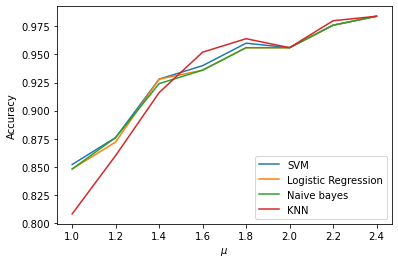

In [56]:
plt.plot(means, svm_accuracies, label='SVM')
plt.plot(means, lr_accuracies, label='Logistic Regression')
plt.plot(means, gnb_accuracies, label='Naive bayes')
plt.plot(means, knn_accuracies, label='KNN')
plt.legend()
plt.xlabel(r'$\mu$')
plt.ylabel('Accuracy')
plt.show()